# Classification with Logistic Regression

Welcome to **Part 2** of **PA1**! Here, you'll build a logistic regression classifier images. In particular, your logistic regression algorithm will state whether the given pic is a cat picture or not. 

<div class="alert alert-warning" markdown=1>**NOTE:** Do **_not_** use loops (`for`/`while`) in your code, unless it's **explicitly** stated to do so.</div>

By the end of this assignment, you should have learned to...
- build the general architecture of a learning algorithm, i.e.
  - initializing parameters
  - calculating the cost function and its gradient
  - using an optimization algorithm (gradient descent)
- Assemble all three functions, above, into a `model` function, in the right order.

---

## 1 - Packages

We'll start out by importing all the needed packages for this assignment:
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with H5 files. We will use that package to read files (datasets).
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are needed to testing your model with a custom picture, at the end.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from utils import dataloader

%matplotlib inline

---

## 2 - Overview of the Problem

**Problem Statement**: You are given a dataset ("data.h5") containing:
  - `m` training images which are labeled `cat (y=1)` or `non-cat (y=0)`
  - `n` test images, which are labeled as `cat` or `non-cat`
  - each image has a shape of `(num_px, num_px, 3)` 
    - 3 specifies the number of color channels (R, G, B)
    - note that these images are square `(h, w, 3) = (num_px, num_px, 3)`

In this second part of the assignment, you'll be building a simple image classifier which "recognizes" cats from non-cats.

First, though, we should get familiar with our dataset; let's run the code below.

In [10]:
# Loading the data (cat/non-cat)
train_x_prep, train_y, test_x_prep, test_y, classes = dataloader()

We added `_prep` at the end of both datasets (`train` and `test`) – this is because we'll be doing some preprocessing on them. Once we've finished preprocessing, we'll have `train_x` and `test_x`. `train_y` and `test_y` don't need an preprocessing, as they're labels.

Each index of `train_x_prep` and `test_x_prep` is an image, represented by an array. Take a peek using `matplotlib` in the next code-cell; **also** consider changing the `idx` to look at other images (this requires re-running the code-cell).

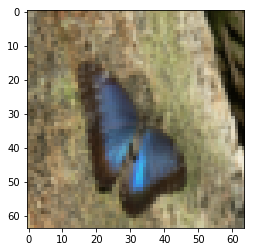

In [11]:
# Example of a picture
idx = 51
plt.imshow(train_x_prep[idx])

<div class="alert alert-info" markdown=1><h2> Exercise 1 </h2></div>

Keep an eye out for differing matrix/vector dimensions – this is the root quite a few bugs in machine learning. Tracking these dimensions will likely keep you away from a number of debugging sessions. :)
- Set the number of training data, number of test data and image width (or height) from the given data.

In [12]:
### START CODE HERE ### (~3 lines of code)
m_train = np.shape(train_x_prep)[0]
n_test = np.shape(test_x_prep)[0]
num_px = np.shape(train_x_prep[0])[0]
### END CODE HERE ###


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: n_test = " + str(n_test))
print ("Image height (or width): num_px = " + str(num_px))
print ("---------------------------------------------- ")
print ("Each image has the dimensions of: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_prep shape (dims): " + str(train_x_prep.shape))
print ("train_y shape (dims): " + str(train_y.shape))
print ("test_x_prep shape (dims): " + str(test_x_prep.shape))
print ("test_y shape (dims): " + str(test_y.shape))



Number of training examples: m_train = 209
Number of testing examples: n_test = 50
Image height (or width): num_px = 64
---------------------------------------------- 
Each image has the dimensions of: (64, 64, 3)
train_x_prep shape (dims): (209, 64, 64, 3)
train_y shape (dims): (1, 209)
test_x_prep shape (dims): (50, 64, 64, 3)
test_y shape (dims): (1, 50)


**Expected Output for `m_train`, `n_test` and `num_px`**:
```python
Number of training examples: m_train = 209
Number of testing examples: n_test = 50
Height/Width of each image: num_px = 64
```

For convenience, you should now reshape images of shape `(num_px, num_px, 3)` in a `np.array` of shape `(num_px * num_px * 3, 1)`. After this, our training (and test) data will be a `np.array` where each column represents a flattened image. There should be `m_train` (and `n_test`) columns.

<div class="alert alert-info" markdown=1><h2> Exercise 2 </h2></div>

Reshape the training and test data sets so that images of size `(num_px, num_px, 3)` are flattened into single vectors of shape `(num_px * num_px * 3, 1)`.

When you want to flatten a matrix `X` with `X.shape = (a, b, c, d)`, to a matrix: `X_flatten` with dims: `X_flatten.shape = (b * c * d, a)`, you can use:
```python
X_flat = X.rshape(X.shape[0], -1).T  # X.T is the transpose of X
```

In [13]:
# Reshape the training and test examples

### START CODE HERE ### (~2 lines of code)
train_x_flat = np.transpose(train_x_prep.reshape(train_x_prep.shape[0], -1))
test_x_flat = np.transpose(test_x_prep.reshape(test_x_prep.shape[0], -1))
### END CODE HERE ###


print ("train_x_flat shape: " + str(train_x_flat.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_flat shape: " + str(test_x_flat.shape))
print ("test_y shape: " + str(test_y.shape))
print ("sanity check after reshaping: " + str(train_x_flat[0:5,0]))





train_x_flat shape: (12288, 209)
train_y shape: (1, 209)
test_x_flat shape: (12288, 50)
test_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 
```python
train_x_flat.shape: (12288, 209)
train_y.shape: (1, 209)
test_x_flat.shape: (12288, 50)
test_y.shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]
```

Color images are represented as 3D matrices in RGB model where the 3rd dimension represents the channels: red, green, and blue (RGB); because of this, each pixel value in an image is actually a 3-tuple (or a vector with 3 elements). Each entry in the RGB model, can have a value between 0 and 255.

A common preprocessing step in machine learning is normalization. A common normalization step can be done by performing the following two lines:
1. substract the mean of the whole `np.array` from each example,
1. divide each example by the standard deviation of the whole `np.array`

However, a convenient trick (an alternative way) is to simple divide each row of the dataset by 255 (the max value of a given pixel channel) – Let's normalize our data by using this technique:

In [14]:
train_x = train_x_flat / 255.
test_x = test_x_flat / 255.

<div class="alert alert-danger" markdown=1><p>**What you need to remember:** </p>
    <p>Common steps for pre-processing a new dataset are:</p>
    <ul>
        <li> Figure out the dimensions and shapes of the data (m_train, m_test, num_px, ...) </li>
        <li> Reshape the data such that each image sample in the data is now a vector of size (num_px \* num_px \* 3, 1)</li>
        <li> Normalize the data</li>
    </ul>
</div>

---

## 3 - Architecture of this Learning Algorithm

Let's finally move on to designing a simple algorithm which can distinguish `cat` containing images from the `non-cat` images.

We'll be building a Logistic Regression as we convered in the class. in the following figure, you'll see an overview of the approach: it is a neural network with a single neuron.

<img src="images/LogRegSummary2.png" style="width: 650px; height: 400px;">

**Let's express the algorithm, mathematically**:

For $i^{(th)}$ example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

We then compute the cost computing the loss for each training example and than taking the average of those losses:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

In the next section, we'll:
- first initialize the parameters of our logistic regression model,
- then learn the parameters for the model by minimizing the cost as defined above,
- use those learned parameters to make predictions (on test data)
- analyze the results 

---

## 4 - Building Component Parts of the Final Algorithm

Primary steps for building a Neural Network:
1. define the model's structure (e.g. the number of input features, number of weights, the bias)
1. initialize the model's parameters
1. loop:
  1. calculate the loss at current iteration with the existing model parameters: $w_i$ and b, (called: forward propagation step)
  1. calculate the gradients at the current iteration (called: backward propagation - backprop step)
  1. update the parameters: $w_i$ and b (use gradient descent)

Typically, you'll first build each of these steps separately, then integrate them into a single `model` function.

### 4.1 - Helper functions

<div class="alert alert-info" markdown=1><h2> Exercise 3 </h2></div>

Using your code from the first part of the assignment, "Intro to Python, featuring `NumPy`", implement `sigmoid()`. As detailed in the figure above, you'll be computing $sigmoid( w^T x + b)$ to make predictions.

In [15]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (~1 line of code)
    s =  1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [16]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(7.1) = " + str(sigmoid(7.1)))

sigmoid(0) = 0.5
sigmoid(7.1) = 0.9991755753136017


**Expected Output**: 
```python
sigmoid(0) = 0.5
sigmoid(7.1) = 0.9991755753136017
```

### 4.2 - Initializing parameters

<div class="alert alert-info" markdown=1><h2> Exercise 4 </h2></div>

Implement parameter initialization in the cell below. You have to initialize `w` as a vector of zeros. If you don't know what numpy function to use, look up `np.zeros()` in the Numpy library's documentation.

In [17]:
def initialize_params_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1). Use np.zeros() function to initialize w
    b -- initialized scalar (corresponds to the bias). You can set this to zero as initial value.
    """
    
    ### START CODE HERE ### (~1 line of code)
    w = np.zeros((dim, 1))
    b = 0.0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [18]:
dim = 2
w, b = initialize_params_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


**Expected Output**: 
```python
w = [[ 0.]
 [ 0.]]
b = 0.0
```

Note that, the dimension is set to 2 in the above test case. For image inputs, the dims of w should be: `w.shape = (num_px * num_px * 3, 1)`.

### 4.3 - Forward and Backward propagation

Not that the parameters are already initialized, you can now compute the "forward" and "backward" propagation steps to learn the parameters (i.e. to update the parameters iteratively).

<div class="alert alert-info" markdown=1><h2> Exercise 5 </h2></div>

Implement a function `propagate()` which computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- First, save all the input data in a single matrix: $X$
- then, compute all the outputs in the matrix form as: $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$
Note that in the above equation computing $\frac{\partial J}{\partial w}$, we used matrix multiplication (but not element-wise multiplication).

In [19]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (~2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -1/m * np.sum(np.multiply(np.log(A), Y) + np.multiply(np.log(1-A), (1-Y)))# compute cost
    ### END CODE HERE ###

    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (~2 lines of code)
    dw = (1 / m) * np.dot(X, (A - Y).T) 
    db = (1 / m) * np.sum(A - Y)
    ### END CODE HERE ###


    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [20]:
w, b, X, Y = np.array([[0.5], [2.]]), 2., np.array([[-1.,2.,-2], [3.,4.,-2.2]]), np.array([[1,0, 1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))


dw = [[1.31197615]
 [2.04240828]]
db = 0.010575328213226301
cost = 4.81113270115668


**Expected Output**:
```python
dw = [[1.31197615]
 [2.04240828]]
db = 0.010575328213226301
cost = 14.43339810347004
```

### 4.4 - Optimization
- Now, you've initialized your parameters, know how to compute the forward and backward steps at a single iteration.
- The next task is to update the model parameters iteratively using gradient descent.

<div class="alert alert-info" markdown=1><h2> Exercise 6 </h2></div>

- Write down the optimization function. The goal is to learn the optimal `w` and `b` values by minimizing the cost function `J`. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [21]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iters, learning_rate, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iters):
        # Cost and gradient calculation (~1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)          # use a function that you previously implemented here.
        
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (~2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw                     # Update the weight with the gradient descent rule. Need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and (i % 100 == 0 or i == num_iters - 1):
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [22]:
params, grads, costs = optimize(w, b, X, Y, num_iters=1000, learning_rate=0.0009)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))


w = [[-0.44605171]
 [ 0.43326516]]
b = 1.8796670598835097
dw = [[0.72771995]
 [1.32830265]]
db = 0.2575613824723859


**Expected Output**: 
```python
w = [[-0.44605171]
 [ 0.43326516]]
b = 1.8796670598835097
dw = [[0.72771995]
 [1.32830265]]
db = 0.2575613824723859
```

<div class="alert alert-info" markdown=1><h2> Exercise 7 </h2></div>

The previous function will return the updated `w` and `b`. We can now use `w` and `b` to predict the labels for given input data: `X`. Implement the `predict()` function below. There are two steps to compute predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$
1. Threshold the entries of A to 0 (`if activation <= 0.5`) or 1 (`if activation > 0.5`); store the predictions in a `Y_pred` vector. For this exercise, you may use an `if/else` statement in a `for` loop. 
  - **NOTE:** There's a way to vectorize this! We strongly encourage you to attempt this, as future submissions will only accept vectorization of operations like this.

In [27]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_pred -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_pred = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute the prediction vector "A" containing the probabilities
    ### START CODE HERE ### (~1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (~4 lines of code)
            if(A[0, i] <= 0.5):
                Y_pred[0, i] = 0
            else:
                Y_pred[0, i] = 1
            
            
        ### END CODE HERE ###
    
    assert(Y_pred.shape == (1, m))
    
    return Y_pred

In [28]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


**Expected Output**: 
- the output has 3 labels for 3 test (toy) samples:
```python
predictions = [[ 1.  1. 0.]]
```


<div class="alert alert-danger" markdown=1><p>**What to remember:**</p>
    <p>You've implemented several functions that:</p>
    <ul>
        <li> Initialize (w,b)</li>
        <li> Optimize the loss iteratively to learn parameters (w,b):<ul>
            <li> computing the cost and its gradient </li>
            <li>updating the parameters using gradient descent</li></ul></li>
        <li> Use the learned (w,b) to predict the labels for a given set of examples</li>
    </ul>
</div>

---

## 5 - Let's Merge the Functions into One

Now, we'll get a feel for the model's overall structure by putting all the individually implemented building blocks together into a single `model` function. (Note that order **_does_** matter.)

<div class="alert alert-info" markdown=1><h2> Exercise 8 </h2></div>

Implement the `model` function. Use the following notation:
- `Y_pred` for your predictions on the testing set
- `Y_pred_train` for your predictions on the training set
- `w, costs, grads` for the outputs of `optimize()`

In [29]:
# GRADED FUNCTION: model
def model(X_train, Y_train, X_test, Y_test, num_iters=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iters -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (~1 line of code)
    w, b = initialize_params_with_zeros(X_train.shape[0])                           #use a function here

    # Gradient descent (~1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iters, learning_rate, print_cost=False)     # use a function here
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_pred_test = predict(w, b, X_test)
    Y_pred_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("")
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))


    
    d = {"costs": costs,
         "Y_pred_test": Y_pred_test, 
         "Y_pred_train" : Y_pred_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iters": num_iters}
    
    return d

Run the following cell to train your model.

In [31]:
d = model(train_x, train_y, test_x, test_y, num_iters=2000, learning_rate=0.005, print_cost=True)


train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**: 
```python

train accuracy: 99.043062201 %
test accuracy: 70.0 %

```



**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test accuracy is 70%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier in the next assignment!


y = 0, your model predicted that this is a "cat" picture.


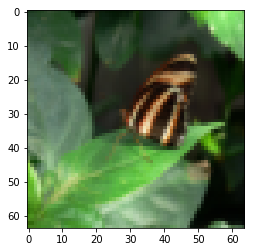

In [32]:
# Example of a picture that was wrongly classified.
index = 5
plt.imshow(test_x[:, index].reshape((num_px, num_px, 3)))

pred = classes[int(d["Y_pred_test"][0, index])].decode("utf-8")
#print(f"y = {test_y[0, index]}, you predict that it's a '{pred}' picture.")





print ("y = " + str(test_y[0, index]) + ", your model predicted that this is a \"" + classes[int(d["Y_pred_test"][0, index])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

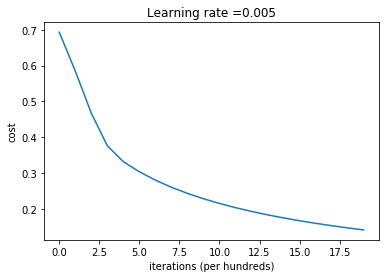

In [33]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

<div class="alert alert-success" markdown=1>Congratulations on building your first image classification model. This assignment has officially completed, **however** we strongly suggest going through the following sections and playing with them to learn further. :)</div>

---

## 6 - Further analysis (optional/ungraded exercise) ##

Let's analyze the model further, and examine possible choices for the learning rate $\alpha$.

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

learning rate is: 0.01

train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001

train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001

train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



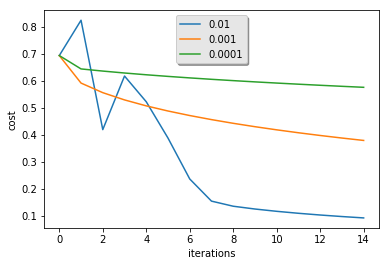

In [34]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_x, train_y, test_x, test_y, num_iters=1500, learning_rate=i)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label=str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

<div class="alert alert-danger" markdown=1><p>**What to take away from this:**</p>
<ul>
    <li> Different learning rates yield different costs and, inherently, different predictions results.</li>
    <li> Large learning rates (e.g. 0.01), may result in costs which oscillate. It may even diverge (though in this assignment using `lr=0.01` still eventually ends up at a good value for the cost). </li>
    <li> A lower cost doesn't necessarily mean a better model. This is due to a problem known as "overfitting," which effectively means your model fails to generalize. It's characterized by having a training accuracy which is much higher than nyour testing accuracy. </li>
    <li> In deep learning, we usually recommend that you: <ul>
        <li> Choose a learning rate which better minimizes the cost function.</li>
        <li> If your model overfits, use other techniques to reduce overfitting. (We'll talk about this later in the course.)</li> 
    </ul></li>
</ul>
</div>

---

## 7 - Test with your own image (optional/ungraded exercise) ##

<div class="alert alert-success" markdown=1>Congratulations on finishing this assignment. You can use your own image and see the output of your model. </div>

To do that:
1. Copy your desired image into the `images/` directory of this assignment.
1. Rename `my_image` in the following code-cell to whatever your image is.
1. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


y = 0.0, your algorithm predicts a "non-cat" picture.


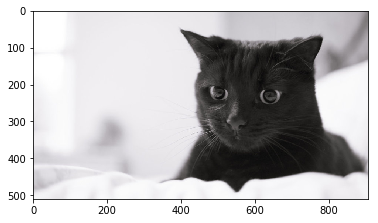

In [37]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "teslacat.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px, num_px)).reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
pred = classes[int(np.squeeze(my_predicted_image)),].decode("utf-8")
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

<div class="alert alert-danger" markdown=1><p>**What to remember:**</p>
    <ol>
        <li>Preprocessing data is important.</li>
        <li>You implemented each function separately: `initialize()`, `propagate()`, `optimize()`. Then combined them to build `model()`.</li>
        <li>Tuning the learning rate (a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in the course and in a few PAs!</li>
    </ol>
</div>

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
- Play with the learning rate and the number of iterations
- Try different initialization methods and compare the results
- Test other preprocessings (center the data, or divide each row by its standard deviation)

[ End of Assignment 1 ]